In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import xlrd
import operator
import math
import re
import nltk
import scipy
import openpyxl
from collections import Counter
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
from pactools.grid_search import GridSearchCVProgressBar

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
df = pd.read_csv("HandelingenRutte2.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t for t in tokenizer.tokenize(x)]))
# Uitschieters weghalen.
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,Mevrouw de voorzitter Dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,Voorzitter Vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,Voorzitter Twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,Voorzitter Alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,Voorzitter We zijn eruit Eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


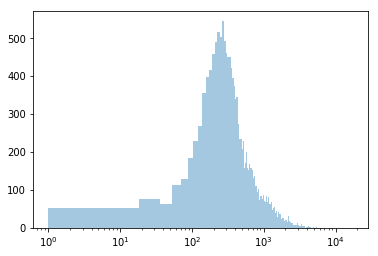

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
f=scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


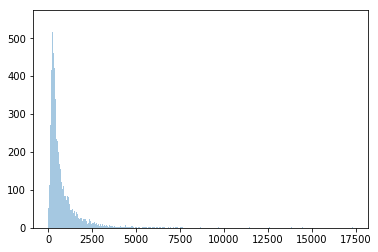

In [4]:
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(f[0]+2*f[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(f[0]-2*f[1])]
print(math.exp(f[0]+2*f[1]),math.exp(f[0]-2*f[1]))
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("mediaan",np.median([len(doc) for doc in list_text]),"gemiddelde",np.mean([len(doc) for doc in list_text]))
print("overgebleven documenten:",len(df))

1492.675589876518 27.339307082607387
mediaan 386.0 gemiddelde 498.18961004094234
overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string
# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


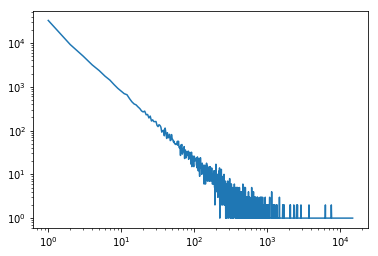

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       387
         CDA       0.12      0.12      0.12      1901
ChristenUnie       0.07      0.07      0.07      1068
         D66       0.13      0.13      0.13      1889
  GroenLinks       0.08      0.08      0.08      1068
         PVV       0.11      0.11      0.11      1700
        PvdA       0.12      0.12      0.12      1821
        PvdD       0.02      0.02      0.02       432
         SGP       0.05      0.05      0.05       655
          SP       0.15      0.15      0.15      2284
         VVD       0.10      0.10      0.10      1694

 avg / total       0.11      0.11      0.11     14899



In [10]:
accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax()))

0.15329887911940399

# Models

In [11]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [12]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}

In [13]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.normal_text)
    else:
        text = list(df.stemmed_text)
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=5)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [14]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_csv(file, index_col=0).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload(False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem
pipe, stem = getbestpipe('Scores.csv')
print(pipe.steps)

[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=1.0,
        vocabulary=None)), ('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5.0, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
if stem:
    pipe.fit(df_train.stemmed_text, df_train.party)
    predicted = pipe.predict(df_test.stemmed_text)
else:
    pipe.fit(list(df_train.normal_text), list(df_train.party))
    predicted = pipe.predict(df_test.normal_text)
print(classification_report(df_test.party, predicted))
print('Accuracy: ', accuracy_score(df_test.party, predicted))

              precision    recall  f1-score   support

      50PLUS       0.95      0.95      0.95        86
         CDA       0.83      0.82      0.82       393
ChristenUnie       0.84      0.78      0.81       200
         D66       0.76      0.82      0.79       391
  GroenLinks       0.92      0.76      0.84       204
         PVV       0.85      0.87      0.86       341
        PvdA       0.74      0.65      0.69       372
        PvdD       0.96      0.88      0.92       107
         SGP       0.82      0.89      0.85       136
          SP       0.76      0.85      0.80       447
         VVD       0.76      0.78      0.77       303

 avg / total       0.81      0.81      0.81      2980

Accuracy:  0.8070469798657718


In [16]:
def mostimportantwords(pipe, countdf, filename):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = []
    for i in range(coefs.shape[0]):
        temp_list = []
        for t in coefs[i].argsort()[-10:][::-1]:
            temp_list.append(inv_vocab[t])
        top_words.append(temp_list)
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    with open("Verslag/Tables/%s1.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,:5].to_latex(index=False))
    with open("Verslag/Tables/%s2.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,5:].to_latex(index=False))
    return top_words

mostimportantwords(pipe, countdf, 'MostImportantWords')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlink,pvv,de pvda,het lid ouwehand,sgp,sp,de vvd
1,het lid krol,het cda,christenunie,led van veldhov,lid van tonger,de pvv,pvda,lid ouwehand nar,de sgp,de sp,vvd
2,lid krol,cda fractie,led voordewind,mijn fractie,led van tonger,islamitisch,de partij van,lid ouwehand,led van der,sp fractie,de vvd is
3,lid krol nar,de cda fractie,de led voordewind,lid van veldhov,led voortman,klever,van de arbeid,vor de dier,de led dijkgraf,de sp fractie,vvd is
4,krol nar mij,de cda,lid dik faber,lid van men,de led voortman,graf,de arbeid,thiem,led dijkgraf,lid leijt nar,de vvd fractie
5,krol nar,lid omtzigt nar,het lid dik,van veldhov,lid voortman,graus,pvda fractie,ouwehand nar mij,sgp fractie,het lid leijt,vvd fractie
6,van 50plus,het lid omtzigt,lid dik,veldhov,het lid voortman,miljard,de pvda fractie,ouwehand nar,de sgp fractie,lid leijt,vor de vvd
7,krol,lid omtzigt,led seger,de led schouw,lid voortman nar,het lid graus,arbeid,de dier,de led bisschop,smaling,wat de vvd
8,50plus is,led geurt,de led seger,led schouw,voortman,lid graus,partij van de,ouwehand,led bisschop,het lid smaling,vvd wil
9,gepensioneerd,de led geurt,led dik faber,led van weyenberg,tonger,klever nar mij,partij van,dier,mevrouw de voorzitter,lid smaling,de vvd wil


In [17]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

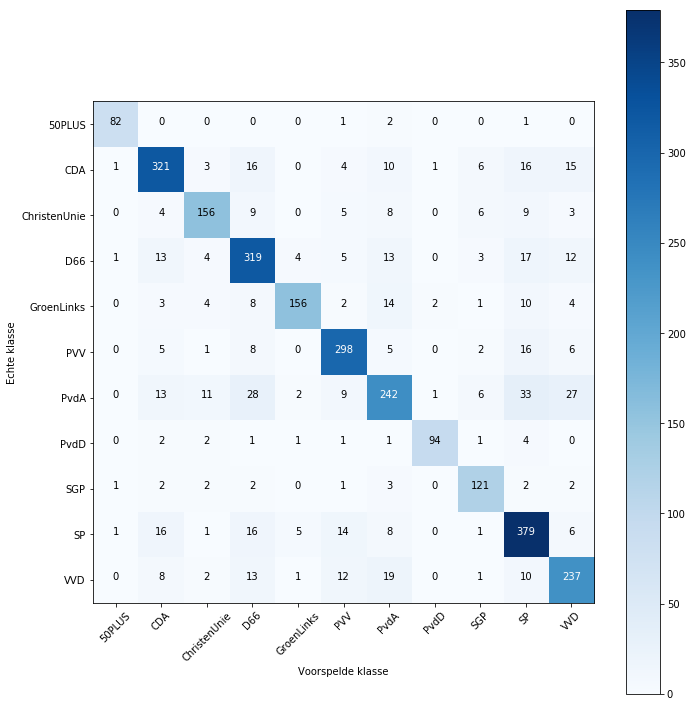

In [18]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix.png")
plt.show()

# Without Names

In [19]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
df['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text,withoutnames
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,Mevrouw de voorzitter Dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,Voorzitter Vorige week plaatsten werkgevers we...,voorzitter vorig wek plaatst werkgever werknem...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,Voorzitter Twee maanden geleden kreeg dit kabi...,voorzitter twee maand geled kreg dit kabinet v...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,Voorzitter Alleen al in de eerste drie maanden...,voorzitter allen al in de eerst drie maand van...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,Voorzitter We zijn eruit Eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekt de mini...


In [20]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.withoutnames), list(df_train.party))
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

      50PLUS       0.80      0.63      0.70        62
         CDA       0.59      0.48      0.53       361
ChristenUnie       0.68      0.44      0.54       227
         D66       0.52      0.53      0.52       379
  GroenLinks       0.68      0.44      0.53       215
         PVV       0.62      0.81      0.70       340
        PvdA       0.50      0.47      0.48       380
        PvdD       0.72      0.70      0.71        89
         SGP       0.70      0.75      0.73       124
          SP       0.53      0.69      0.60       441
         VVD       0.52      0.52      0.52       362

 avg / total       0.58      0.57      0.57      2980



In [21]:
mostimportantwords(pipe, countdf, 'MostImportantWordsWithoutNames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerd,partijnaam fractie,gezinn,mijn fractie,zou,islamitisch,circulair,dier,mevrouw de voorzitter,huurder,partijnaam
1,ouder,inwoner,mensenhandel,mijn,schon energie,nederland,jonger,klimaatverander,mevrouw de,zegt,volgen mij
2,plusser,reger,inderdad,buitengewon,schon,miljard,wijkverpleegkund,dierenwelzijn,eenverdiener,de bevolk,aruba
3,koopkrachtontwikkel,partijnaam,rookvrij,natur,belastingontwijk,brussel,die,milieu,punt,armoed,essentieel
4,50 plusser,de reger,koerd,vandag,in elk geval,al,hulpverlener,industrie,beantwoord,mens,regelgev
5,partijnaam,echt,geestelijk,fractie,kamer hierover te,belastingbetaler,toezegg,burger,vor de beantwoord,bezuin,ban
6,overweg dat,wij,genocid,het kabinet,elk geval,natur,open standaard,bio,nar vor,mening dat,partijnaam fractie
7,ouderenwerklos,hier,elkar,daarom,in elk,uitkoopregel,lager over,constater dat,mar,voorstell,volgen
8,overweg,uiteind,christen,kabinet,bewindsperson,dit kabinet,daarbij,bio industrie,de beantwoord,bevolk,speelveld
9,werkend,fractie,ik hop,minister,sekswerker,islam,gezamen,de bio,voorzitter ik,van mening dat,wellicht


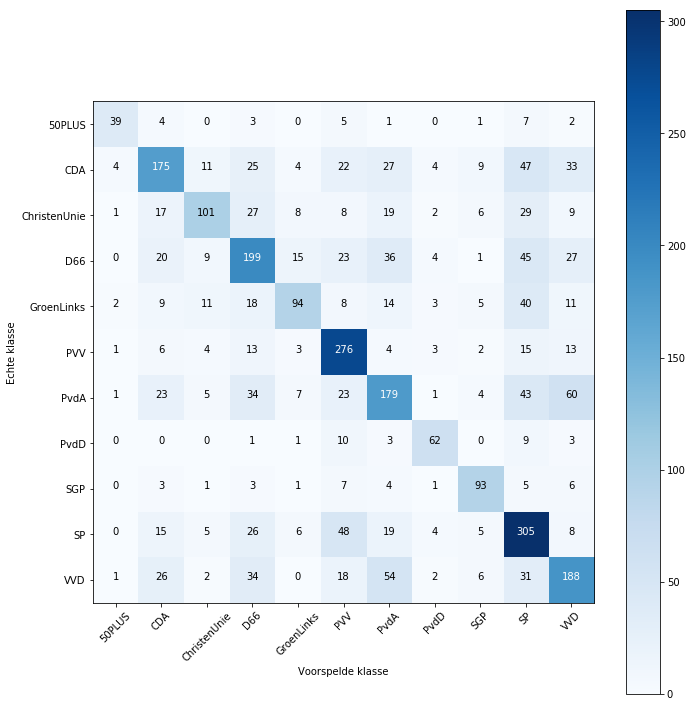

In [22]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix2.png")
plt.show()

# Regering & Oppositie

In [23]:
df['PartijStatus'] = df['party'].map({'CDA': 'Oppositie', 'ChristenUnie': 'Oppositie', 'D66':'Oppositie', 'SGP':'Oppositie', 'VVD':'Regering', 'SP':'Oppositie','PvdD':'Oppositie','GroenLinks':'Oppositie','PvdA':'Regering','50PLUS':'Oppositie'})
pipe, _ = getbestpipe('Scores.csv')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.PartijStatus)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.PartijStatus, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


             precision    recall  f1-score   support

  Oppositie       0.81      0.97      0.88      1939
   Regering       0.82      0.38      0.52       701

avg / total       0.81      0.81      0.79      2640



In [24]:
# regering
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[-10:][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

,0
0,partij
1,volgen mij
2,toezegg
3,constater
4,wij
5,al
6,blij
7,huis
8,stap
9,all


In [25]:
# oppositie
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[:10][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

,0
0,niet
1,bezuin
2,kabinet
3,eigen
4,fractie
5,toch
6,zegt
7,minister
8,waarom
9,mijn fractie


# Woorden Balkenende 4

In [26]:
# Importing data
dfb4 = pd.read_csv("HandelingenBalkenende4.csv", index_col=0)
dfb4 = dfb4.loc[dfb4['speech category'] == 'Main Speech']
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text
5119,Marijnissen,SP,Voorzitter. Wij spreken vandaag voor het eerst...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,voorzitter wij sprek vandag vor het eerst met ...
5135,Van Geel,CDA,Mevrouw de voorzitter. Er is mij gevraagd naar...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter er is mij gevraagd nar h...
5191,Rutte,VVD,Mevrouw de voorzitter. Wij voeren vandaag een ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter wij voer vandag een bela...
5238,Tichelaar,PvdA,Mevrouw de voorzitter. Laat ik beginnen met he...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter lat ik beginn met het ni...
5275,Wilders,PVV,Mevrouw de voorzitter. Zeer veel dank voor het...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter zer vel dank vor het ver...


In [27]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

CDA             1348
ChristenUnie     674
D66              623
GroenLinks       901
PVV             1143
PvdA            1204
PvdD             215
SGP              570
SP              1499
VVD             1323
Name: party, dtype: int64

In [28]:
Party_synomyns
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
dfb4['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,withoutnames
5119,Marijnissen,SP,Voorzitter. Wij spreken vandaag voor het eerst...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,voorzitter wij sprek vandag vor het eerst met ...,voorzitter wij sprek vandag vor het eerst met ...
5135,Van Geel,CDA,Mevrouw de voorzitter. Er is mij gevraagd naar...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter er is mij gevraagd nar h...,mevrouw de voorzitter er is mij gevraagd nar h...
5191,Rutte,VVD,Mevrouw de voorzitter. Wij voeren vandaag een ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter wij voer vandag een bela...,mevrouw de voorzitter wij voer vandag een bela...
5238,Tichelaar,PvdA,Mevrouw de voorzitter. Laat ik beginnen met he...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter lat ik beginn met het ni...,mevrouw de voorzitter lat ik beginn met het ni...
5275,Wilders,PVV,Mevrouw de voorzitter. Zeer veel dank voor het...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter zer vel dank vor het ver...,mevrouw de voorzitter zer vel dank vor het ver...


In [29]:
pipe, _ = getbestpipe('Scores.csv')
dfb4_train = dfb4.sample(frac=0.8)
dfb4_test_index = list(set(dfb4.index.tolist()) - set(dfb4_train.index.tolist()))
dfb4_test = dfb4[dfb4.index.isin(dfb4_test_index)]
pipe.fit(list(dfb4_train.withoutnames), list(dfb4_train.party))
predicted = pipe.predict(dfb4_test.withoutnames)
print(classification_report(dfb4_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.61      0.64      0.62       281
ChristenUnie       0.64      0.55      0.59       145
         D66       0.74      0.50      0.60       112
  GroenLinks       0.68      0.66      0.67       186
         PVV       0.62      0.67      0.64       249
        PvdA       0.58      0.34      0.43       233
        PvdD       0.79      0.46      0.58        41
         SGP       0.74      0.83      0.78       122
          SP       0.59      0.65      0.62       289
         VVD       0.42      0.57      0.48       242

 avg / total       0.61      0.60      0.59      1900



In [30]:
mostimportantwords(pipe, countdfb4, 'MostImportantWordsWithoutNames')

,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,partijnaam fractie,fractie van partijnaam,hervorm,partijnaamfractie,burger,geweld,dier,mijn fractie,lerar,onz fractie
1,wij,de fractie van,patient,premier,immigratie,vrouw,dierproev,wel,zegt,partijnaam
2,buitengewon,de fractie,arbeidsmarkt,fractie van partijnaam,de burger,wij,duurzam,uitdruk,mens,partijnaam fractie
3,fractie,fractie van,schon energie,de fractie,dez,volgen mij,bio industrie,toch,bezuin,fractie
4,aangegev,verschill,dadelijk,de fractie van,niet,groep,de bio,diver,fractie dient,ondernemer
5,element,moment,europa,mij,belastinggeld,all,de bio industrie,natur,ontslag,kamerlidnaamman
6,toezegg,partijnaamfractie,ik hop,deal,gewon,de werkgroep,de natur,helder,waarom,awbz
7,om,volgen mij,de arbeidsmarkt,fractie van,dor,wet,japan,positief,thuiszorg,liberal
8,wij hebb,coalitieakkoord,alleenstaand,politiek,volk,iederen,de dier,beantwoord,voorstell,markt
9,nadruk,uitgebreid,welk,beetj,onz,dus,kiezer,allerlei,bureaucratie,echt


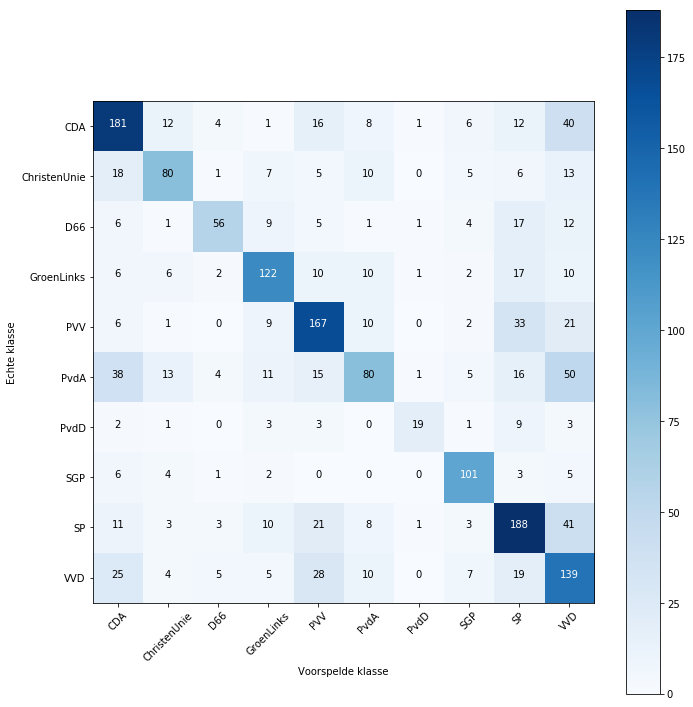

In [31]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(dfb4_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(dfb4.party.unique())), \
                      title='Confusion matrix best estimator')
plt.show()

# Vergelijken

In [32]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(tempdf.withoutnames, tempdf.party)
predicted = pipe.predict(dfb4.withoutnames)
print(classification_report(dfb4.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.30      0.34      0.32      1348
ChristenUnie       0.45      0.20      0.28       674
         D66       0.19      0.27      0.22       623
  GroenLinks       0.23      0.06      0.10       901
         PVV       0.44      0.65      0.52      1143
        PvdA       0.31      0.30      0.31      1204
        PvdD       0.57      0.53      0.55       215
         SGP       0.41      0.61      0.49       570
          SP       0.45      0.49      0.47      1499
         VVD       0.19      0.14      0.17      1323

 avg / total       0.34      0.35      0.33      9500



In [33]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(dfb4.withoutnames, dfb4.party)
predicted = pipe.predict(tempdf.withoutnames)
print(classification_report(tempdf.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.21      0.25      0.23      1901
ChristenUnie       0.25      0.13      0.17      1068
         D66       0.23      0.20      0.21      1889
  GroenLinks       0.17      0.09      0.12      1068
         PVV       0.45      0.62      0.52      1700
        PvdA       0.29      0.30      0.30      1821
        PvdD       0.65      0.27      0.38       432
         SGP       0.50      0.44      0.47       655
          SP       0.34      0.57      0.43      2284
         VVD       0.23      0.11      0.14      1694

 avg / total       0.30      0.32      0.29     14512



# Links / Rechts vergelijken

In [34]:
df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.Kieskompas)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.Kieskompas, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Git

In [ ]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Verslag/Tables/lengthtextslog.png
!git add Verslag/Tables/lengthtexts.png
!git add Models.xlsx
!git add Verslag/confusionmatrix.png
!git commit -m Update
!git push